-----------
### Download dataset and pre-preocessing via Torchvision for classification task

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# PyTorch TensorBoard support
# from torch.utils.tensorboard import SummaryWriter
# !pip install tensorboardX
# from tensorboardX import SummaryWriter
from datetime import datetime


transform = transforms.Compose(
        [transforms.Resize((224, 224)),
         transforms.Grayscale(num_output_channels=3),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Create datasets for training & validation, download if necessary
# --- handwritten
# training_set = torchvision.datasets.USPS('./data', train=True, transform=transform, download=True)
# validation_set = torchvision.datasets.USPS('./data', train=False, transform=transform, download=True)
# training_set = torchvision.datasets.MNIST('./data', train=True, transform=transform, download=True)
# validation_set = torchvision.datasets.MNIST('./data', train=False, transform=transform, download=True)
# --- object recognition
"""

  Arg:
    Example: Caltech-101 dataset
    About dataset: The Caltech101 dataset contains images from 101 object categories
    (e.g., “helicopter”, “elephant” and “chair” etc.) and a background category that
    contains the images not from the 101 object categories. For each object category,
    there are about 40 to 800 images, while most classes have about 50 images.
    The resolution of the image is roughly about 300×200 pixels.
    Ref: https://pytorch.org/vision/main/generated/torchvision.datasets.Caltech101.html

"""
train_split = 0.8
training_set = torchvision.datasets.Caltech101('./data', transform=transform, download=True)
train_size = int(train_split * len(training_set))
test_size = len(training_set) - train_size
training_set, validation_set = torch.utils.data.random_split(training_set, [train_size, test_size])


# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=16, shuffle=False)

# Class labels
# classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Downloading...
From (original): https://drive.google.com/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp
From (redirected): https://drive.usercontent.google.com/download?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp&confirm=t&uuid=96d7aaa1-8a17-4191-b5d3-8a66ef625d23
To: /content/data/caltech101/101_ObjectCategories.tar.gz
100%|██████████| 132M/132M [00:06<00:00, 19.3MB/s]


Extracting ./data/caltech101/101_ObjectCategories.tar.gz to ./data/caltech101


Downloading...
From (original): https://drive.google.com/uc?id=175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m
From (redirected): https://drive.usercontent.google.com/download?id=175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m&confirm=t&uuid=1b01f774-d09a-4e6a-a81f-ceb4ac1470a2
To: /content/data/caltech101/Annotations.tar
100%|██████████| 14.0M/14.0M [00:00<00:00, 109MB/s] 


Extracting ./data/caltech101/Annotations.tar to ./data/caltech101
Training set has 6941 instances
Validation set has 1736 instances


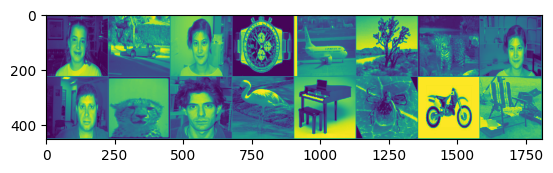

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg)
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
# print('  '.join(classes[labels[j]] for j in range(16)))

In [ ]:
def plot_graph(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.suptitle("Train vs Validation")
    ax1.plot(history["train_acc"], label="Train")
    ax1.plot(history["validate_acc"], label="Validation")
    ax1.legend()
    ax1.set_title("Accuracy")

    ax2.plot(history["train_loss"], label="Train")
    ax2.plot(history["validate_loss"], label="Validation")
    ax2.legend()
    ax2.set_title("Loss")
    fig.show()

In [ ]:
import os
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import time

#---Variable initialization---
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#-----------------------------

#### Create prievous SOTA model and import pre-trained model from torchvision

VGG-16
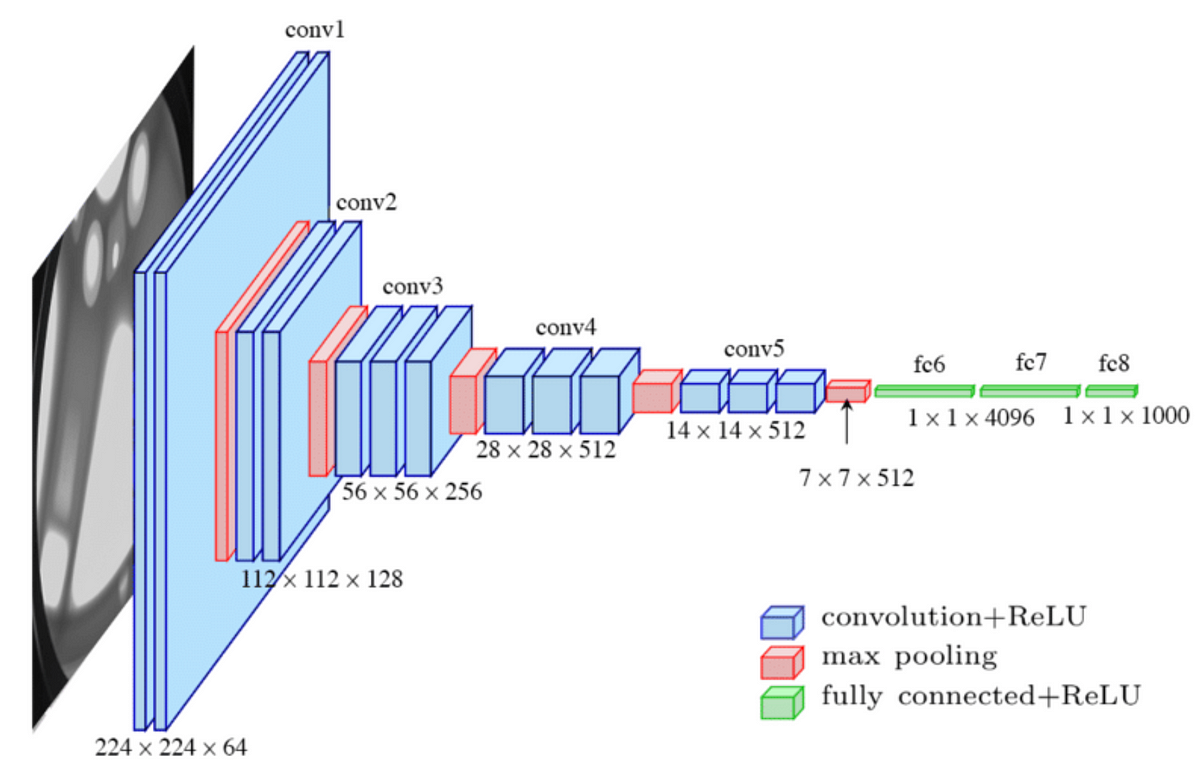

In [ ]:
# VGG-16
class VGG16(nn.Module):
    def __init__(self, n_C=10):
        super(VGG16, self).__init__()
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)

        self.conv2_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)

        self.conv3_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv3_23 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)

        self.conv4_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv4_23_5_123 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(512 * 7 * 7, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, n_C)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1_2(self.conv1_1(x))))
        x = self.pool(F.relu(self.conv2_2(self.conv2_1(x))))
        x = self.pool(F.relu(self.conv3_23(self.conv3_23(self.conv3_1(x)))))
        x = self.pool(F.relu(self.conv4_23_5_123(self.conv4_23_5_123(self.conv4_1(x)))))
        x = self.pool(F.relu(self.conv4_23_5_123(self.conv4_23_5_123(self.conv4_23_5_123(x)))))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# --- Weights from torch.load
# In case: load saved checkpoint
model_urls = {
     'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth'
     }
!pip install wget
import wget
def download_n_load_model(model, model_name):
    if model_name in model_urls:
      if not os.path.exists(f"{model_name}.pth"):
        url = model_urls[model_name]
        wget.download(url, out=f"{model_name}.pth")
      rn_model_dict=model.state_dict()
      url = model_urls[model_name]
      pretrained_dict = torch.load(f'./{model_name}.pth')
      pretrained_dict = {k: v for k, v in pretrained_dict.items() if (k in rn_model_dict) and (rn_model_dict[k].shape == pretrained_dict[k].shape)}
      rn_model_dict.update(pretrained_dict)
      model.load_state_dict(rn_model_dict)
      print(f"load checkpoint...{model_name}")






# model and pretrained_weight (if any or required)
model = VGG16(n_C=10).to(device)
download_n_load_model(model, 'vgg16')





# --- From Torchvision
vgg16 = torchvision.models.VGG16(pretrained=True)
num_features = list(vgg16.children())[-1].in_features
model = nn.Sequential(*list(vgg16.children())[:-1],
                      nn.Linear(num_features, 10)
                      ) # throw away old fc layers
print(model)
# /////////////////////////////////////////////////////////////////////////////

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=2e3b53202c9c874636c0497f7898fb306fd99cbbcdebabbe5aa507cf15c718b2
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


<ipython-input-5-845ef3cd7549>:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load(f'./{model_name}.pth')


load checkpoint...vgg16


ResNet-18

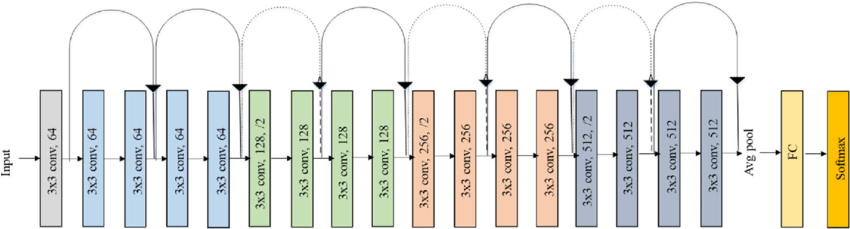

ResNet-34
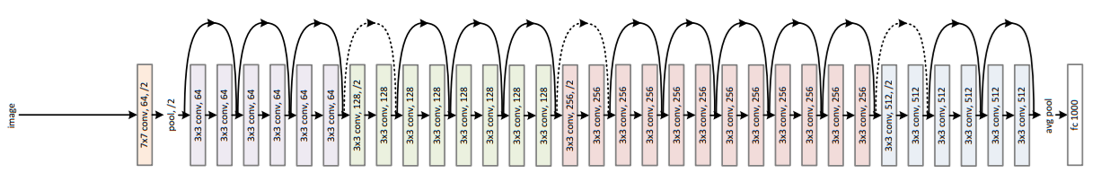

In [ ]:
# /////////////////////// ResNet-[18, 34, 50, 101, 152] /////////////////////////////////
# --- From scratch
'''
ResNet in PyTorch.

For Pre-activation ResNet, see 'preact_resnet.py'.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
Web-ref:
    https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py
'''
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        # self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.maxpool(F.relu(self.bn1(self.conv1(x))))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# Model Selection
def ResNet18(n_C=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=n_C)

def ResNet34(n_C=10):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=n_C)

def ResNet50(n_C=10):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=n_C)

def ResNet101(n_C=10):
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes=n_C)

def ResNet152(n_C=10):
    return ResNet(Bottleneck, [3, 8, 36, 3], num_classes=n_C)

# --- Weights from torch.load
# In case: load saved checkpoint
model_urls = {
     'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
     'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
     'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
     'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
     'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
    #  'resnext50_32x4d': 'https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth',
    #  'resnext101_32x8d': 'https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth',
    #  'wide_resnet50_2': 'https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth',
    #  'wide_resnet101_2': 'https://download.pytorch.org/models/wide_resnet101_2-32ee1156.pth',
 }
!pip install wget
import wget
def download_n_load_model(model, model_name):
    if model_name in model_urls:
      if not os.path.exists(f"{model_name}.pth"):
        url = model_urls[model_name]
        wget.download(url, out=f"{model_name}.pth")
      rn_model_dict=model.state_dict()
      url = model_urls[model_name]
      pretrained_dict = torch.load(f'./{model_name}.pth')
      pretrained_dict = {k: v for k, v in pretrained_dict.items() if (k in rn_model_dict) and (rn_model_dict[k].shape == pretrained_dict[k].shape)}
      rn_model_dict.update(pretrained_dict)
      model.load_state_dict(rn_model_dict)
      print(f"load checkpoint...{model_name}")





# model and pretrained_weight (if any or required)
model = ResNet50(n_C=10).to(device)
download_n_load_model(model, 'resnet50')






# --- (Optional) Weight and model from Torchvision
# resnet = torchvision.models.resnet18(pretrained=True)   # re-define sub-module of resnet as {18, 34, 50, 101, 152}
# num_features = list(resnet.children())[-1].in_features
# model = nn.Sequential(*list(resnet.children())[:-1],
#                       nn.Flatten(),
#                       nn.Linear(num_features, 10)
#                       ) # throw away old fc layers
# print(model)
# /////////////////////////////////////////////////////////////////////////////

<ipython-input-6-7e3a356bab0f>:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load(f'./{model_name}.pth')


load checkpoint...resnet50


SENet
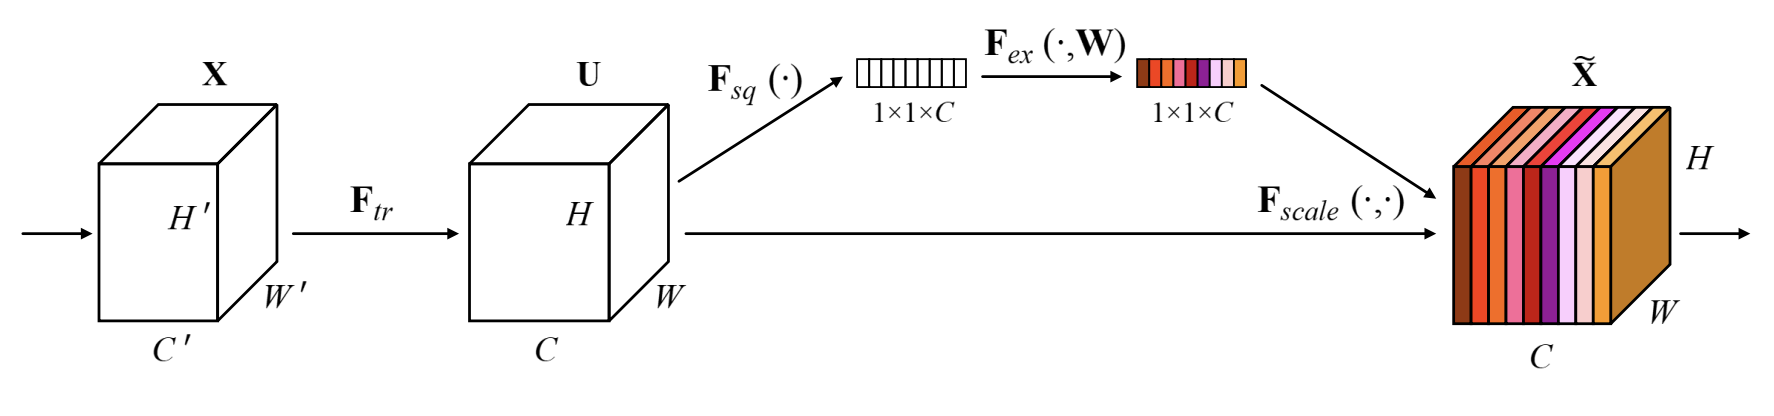
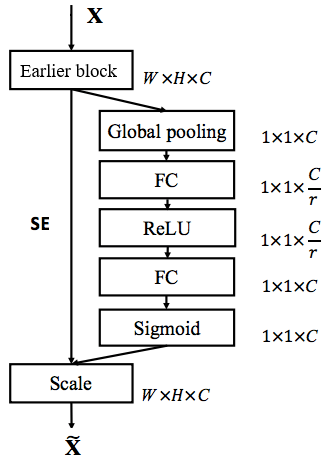

In [ ]:
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(SEBlock, self).__init__()
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)  # Global average pooling

        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction, bias=False), # Use Linear layers instead of Conv2d
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction, in_channels, bias=False),
            nn.Sigmoid()  # Outputs scale factors for each channel
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.global_avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1) # Reshape to match the spatial dimensions of x
        return x * y  # Scale features

MobileNetV2
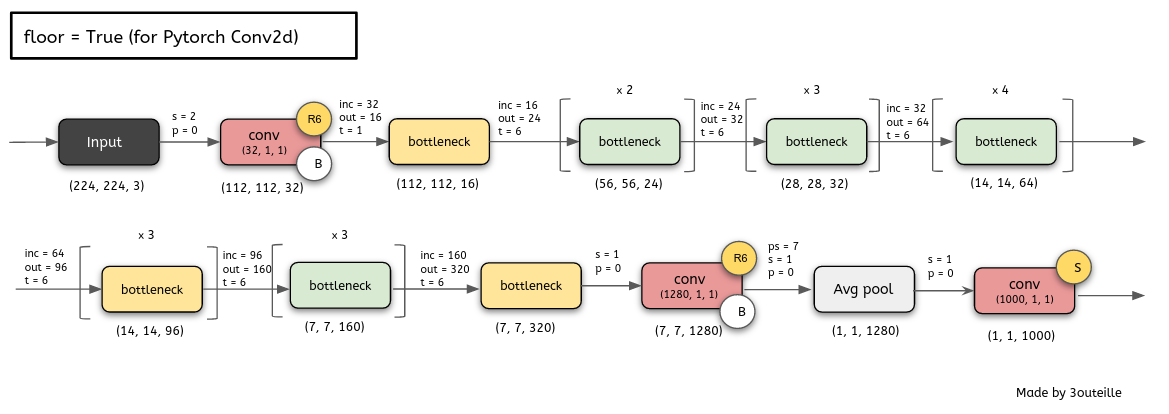

In [ ]:
# MobileNetV2
import torch.nn as nn
import math

'''
model architecture reference: https://colab.research.google.com/drive/126qar8_1Neyg1lNXKpT0KDs7cUElBH_T
'''


def conv_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )


def make_divisible(x, divisible_by=8):
    import numpy as np
    return int(np.ceil(x * 1. / divisible_by) * divisible_by)


class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(inp * expand_ratio)
        self.use_res_connect = self.stride == 1 and inp == oup

        if expand_ratio == 1:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)


class MobileNetV2(nn.Module):
    def __init__(self, n_C=1000, input_size=224, width_mult=1.):
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = 32
        last_channel = 1280
        interverted_residual_setting = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        # building first layer
        assert input_size % 32 == 0
        # input_channel = make_divisible(input_channel * width_mult)  # first channel is always 32!
        self.last_channel = make_divisible(last_channel * width_mult) if width_mult > 1.0 else last_channel
        self.features = [conv_bn(3, input_channel, 2)]
        # building inverted residual blocks
        for t, c, n, s in interverted_residual_setting:
            output_channel = make_divisible(c * width_mult) if t > 1 else c
            for i in range(n):
                if i == 0:
                    self.features.append(block(input_channel, output_channel, s, expand_ratio=t))
                else:
                    self.features.append(block(input_channel, output_channel, 1, expand_ratio=t))
                input_channel = output_channel
        # building last several layers
        self.features.append(conv_1x1_bn(input_channel, self.last_channel))
        # make it nn.Sequential
        self.features = nn.Sequential(*self.features)

        # building classifier
        self.classifier = nn.Linear(self.last_channel, n_C)

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.mean(3).mean(2)   #flatteining like x=x.view(x.size(0), x.size(1),)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()


def mobilenet_v2(pretrained=True):
    model = MobileNetV2(width_mult=1)

    if pretrained:
        try:
            from torch.hub import load_state_dict_from_url
        except ImportError:
            from torch.utils.model_zoo import load_url as load_state_dict_from_url
        state_dict = load_state_dict_from_url(
            'https://www.dropbox.com/s/47tyzpofuuyyv1b/mobilenetv2_1.0-f2a8633.pth.tar?dl=1', progress=True)
        model.load_state_dict(state_dict)
    return model

MobileNetV3-Large\
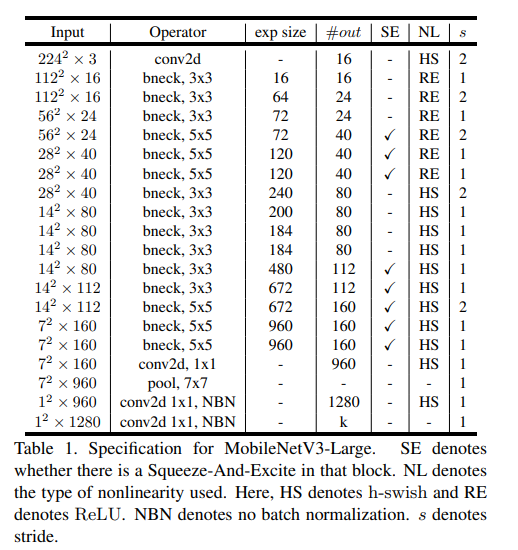

MobileNetV3-Small\
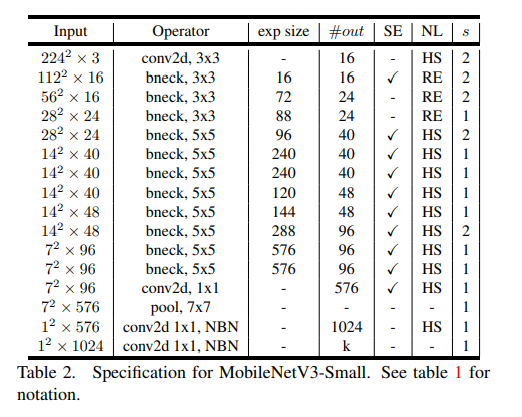

In [ ]:
# MobileNetV3 Large (L) & Small (S)
import torch.nn as nn
import math

'''
MobileNetV3 From <Searching for MobileNetV3>, arXiv:1905.02244.
Arg:
    Creates a MobileNetV3 Model as defined in:
    Andrew Howard, Mark Sandler, Grace Chu, Liang-Chieh Chen, Bo Chen, Mingxing Tan, Weijun Wang, Yukun Zhu, Ruoming Pang, Vijay Vasudevan, Quoc V. Le, Hartwig Adam. (2019).
    Searching for MobileNetV3
    arXiv preprint arXiv:1905.02244.
Ref:
    https://github.com/d-li14/mobilenetv3.pytorch/blob/master/mobilenetv3.py
    https://github.com/kuan-wang/pytorch-mobilenet-v3/blob/master/mobilenetv3.py

'''
__all__ = ['mobilenetv3_large', 'mobilenetv3_small']


def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_value:
    :return:
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


class h_sigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(h_sigmoid, self).__init__()
        self.relu = nn.ReLU6(inplace=inplace)

    def forward(self, x):
        return self.relu(x + 3) / 6


class h_swish(nn.Module):
    def __init__(self, inplace=True):
        super(h_swish, self).__init__()
        self.sigmoid = h_sigmoid(inplace=inplace)

    def forward(self, x):
        return x * self.sigmoid(x)


class SELayer(nn.Module):
    def __init__(self, channel, reduction=4):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
                nn.Linear(channel, _make_divisible(channel // reduction, 8)),
                nn.ReLU(inplace=True),
                nn.Linear(_make_divisible(channel // reduction, 8), channel),
                h_sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


def conv_3x3_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        h_swish()
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        h_swish()
    )


class InvertedResidual(nn.Module):
    def __init__(self, inp, hidden_dim, oup, kernel_size, stride, use_se, use_hs):
        super(InvertedResidual, self).__init__()
        assert stride in [1, 2]

        self.identity = stride == 1 and inp == oup

        if inp == hidden_dim:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, kernel_size, stride, (kernel_size - 1) // 2, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # Squeeze-and-Excite
                SELayer(hidden_dim) if use_se else nn.Identity(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, kernel_size, stride, (kernel_size - 1) // 2, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                # Squeeze-and-Excite
                SELayer(hidden_dim) if use_se else nn.Identity(),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.identity:
            return x + self.conv(x)
        else:
            return self.conv(x)


class mobilenetv3_large(nn.Module):
    def __init__(self,
                 n_C=1000,
                 width_mult=1.,
                 ):
        super(mobilenetv3_large, self).__init__()
        # setting of inverted residual blocks
        self.cfgs = [
        # k, t, c, SE, HS, s
        [3,   1,  16, 0, 0, 1],
        [3,   4,  24, 0, 0, 2],
        [3,   3,  24, 0, 0, 1],
        [5,   3,  40, 1, 0, 2],
        [5,   3,  40, 1, 0, 1],
        [5,   3,  40, 1, 0, 1],
        [3,   6,  80, 0, 1, 2],
        [3, 2.5,  80, 0, 1, 1],
        [3, 2.3,  80, 0, 1, 1],
        [3, 2.3,  80, 0, 1, 1],
        [3,   6, 112, 1, 1, 1],
        [3,   6, 112, 1, 1, 1],
        [5,   6, 160, 1, 1, 2],
        [5,   6, 160, 1, 1, 1],
        [5,   6, 160, 1, 1, 1]
        ]

        # building first layer
        input_channel = _make_divisible(16 * width_mult, 8)
        layers = [conv_3x3_bn(3, input_channel, 2)]
        # building inverted residual blocks
        block = InvertedResidual
        for k, t, c, use_se, use_hs, s in self.cfgs:
            output_channel = _make_divisible(c * width_mult, 8)
            exp_size = _make_divisible(input_channel * t, 8)
            layers.append(block(input_channel, exp_size, output_channel, k, s, use_se, use_hs))
            #print("layers:",len(layers))    #16
            input_channel = output_channel
        self.features = nn.Sequential(*layers)

        # building last several layers
        self.conv = conv_1x1_bn(input_channel, exp_size)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        output_channel = 1280
        output_channel = _make_divisible(output_channel * width_mult, 8) if width_mult > 1.0 else output_channel
        self.classifier = nn.Sequential(
            nn.Linear(exp_size, output_channel),
            h_swish(),
            nn.Dropout(0.2),
            nn.Linear(output_channel, n_C),
        )
        self._initialize_weights()

    def forward(self, x):
        # x = self.features(x)
        # encoder
        x = self.features[0](x) #conv2d
        x = self.features[1](x) #bneck 3x3
        x = self.features[2](x) #bneck 3x3
        x = self.features[3](x) #bneck 3x3
        x = self.features[4](x) #bneck 5x5
        x = self.features[5](x) #bneck 5x5
        x = self.features[6](x) #bneck 5x5
        x = self.features[7](x) #bneck 3x3
        x = self.features[8](x) #bneck 3x3
        x = self.features[9](x) #bneck 3x3
        x = self.features[10](x) #bneck 3x3
        x = self.features[11](x) #bneck 3x3
        x = self.features[12](x) #bneck 3x3
        x = self.features[13](x) #bneck 5x5
        x = self.features[14](x) #bneck 5x5
        x = self.features[15](x) #bneck 5x5
        x = self.conv(x)

        x = self.avgpool(x)
        fc = x.view(x.size(0), -1)
        out = self.classifier(fc)

        return out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()



class mobilenetv3_small(nn.Module):
    def __init__(self,
                 n_C=1000,
                 width_mult=1.,
                 ):
        super(mobilenetv3_small, self).__init__()
        # setting of inverted residual blocks
        self.cfgs = [
        # k, t, c, SE, HS, s
        [3,    1,  16, 1, 0, 2],
        [3,  4.5,  24, 0, 0, 2],
        [3, 3.67,  24, 0, 0, 1],
        [5,    4,  40, 1, 1, 2],
        [5,    6,  40, 1, 1, 1],
        [5,    6,  40, 1, 1, 1],
        [5,    3,  48, 1, 1, 1],
        [5,    3,  48, 1, 1, 1],
        [5,    6,  96, 1, 1, 2],
        [5,    6,  96, 1, 1, 1],
        [5,    6,  96, 1, 1, 1],
        ]

        # building first layer
        input_channel = _make_divisible(16 * width_mult, 8)
        layers = [conv_3x3_bn(3, input_channel, 2)]
        # building inverted residual blocks
        block = InvertedResidual
        for k, t, c, use_se, use_hs, s in self.cfgs:
            output_channel = _make_divisible(c * width_mult, 8)
            exp_size = _make_divisible(input_channel * t, 8)
            layers.append(block(input_channel, exp_size, output_channel, k, s, use_se, use_hs))
            #print("layers:",len(layers))    #12
            input_channel = output_channel
        self.features = nn.Sequential(*layers)

        # building last several layers
        self.conv = conv_1x1_bn(input_channel, exp_size)    # For regular and latent feature inputs
        #self.conv = conv_1x1_bn(48, exp_size) # For adjusting last feature enoced layer (pre-exit): [16, 20, 24, 40, 48]
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        output_channel = 1024
        output_channel = _make_divisible(output_channel * width_mult, 8) if width_mult > 1.0 else output_channel
        self.classifier = nn.Sequential(
            nn.Linear(exp_size, output_channel),
            h_swish(),
            nn.Dropout(0.2),
            nn.Linear(output_channel, n_C),
        )
        self._initialize_weights()

    def forward(self, x):
        # x = self.features(x)
        # encoder
        x = self.features[0](x) #conv2d
        x = self.features[1](x) #bneck 3x3
        x = self.features[2](x) #bneck 3x3
        x = self.features[3](x) #bneck 3x3
        x = self.features[4](x) #bneck 5x5
        x = self.features[5](x) #bneck 5x5
        x = self.features[6](x) #bneck 5x5
        x = self.features[7](x) #bneck 5x5
        x = self.features[8](x) #bneck 5x5
        x = self.features[9](x) #bneck 5x5
        x = self.features[10](x) #bneck 5x5
        x = self.features[11](x) #bneck 5x5
        x = self.conv(x)

        x = self.avgpool(x)
        fc = x.view(x.size(0), -1)
        out = self.classifier(fc)

        return out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()


# load pretrained weights from torchvision modelzoo
!pip install wget
import wget
model_urls = {
     'mobilenetv3_small': 'https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth',
     'mobilenetv3_large': 'https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth'
 }
def download_n_load_model(model, model_name):
    if model_name in model_urls:
      if not os.path.exists(f"{model_name}.pth"):
        url = model_urls[model_name]
        wget.download(url, out=f"{model_name}.pth")
      rn_model_dict=model.state_dict()
      url = model_urls[model_name]
      pretrained_dict = torch.load(f'./{model_name}.pth')
      pretrained_dict = {k: v for k, v in pretrained_dict.items() if (k in rn_model_dict) and (rn_model_dict[k].shape == pretrained_dict[k].shape)}
      rn_model_dict.update(pretrained_dict)
      model.load_state_dict(rn_model_dict)
      print(f"load checkpoint...{model_name}")





###########################################################################
# Define model in use
# vvvvvvvvvvvvvvvvvvvvvv
pretrained_weight = False
mbv3_type = 'small'
# ^^^^^^^^^^^^^^^^^^^^^^

if mbv3_type=='large':
  model = mobilenetv3_large(n_C=10, width_mult=1.).to(device)
elif mbv3_type=='small':
  model = mobilenetv3_small(n_C=10, width_mult=1.).to(device)

if pretrained_weight and mbv3_type=='large':
  download_n_load_model(model, 'mobilenetv3_large')
elif pretrained_weight and mbv3_type=='small':
  download_n_load_model(model, 'mobilenetv3_small')

In [ ]:
# Model init
model = model.to(device)
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
             ReLU6-3         [-1, 16, 112, 112]               0
         h_sigmoid-4         [-1, 16, 112, 112]               0
           h_swish-5         [-1, 16, 112, 112]               0
            Conv2d-6           [-1, 16, 56, 56]             144
       BatchNorm2d-7           [-1, 16, 56, 56]              32
              ReLU-8           [-1, 16, 56, 56]               0
 AdaptiveAvgPool2d-9             [-1, 16, 1, 1]               0
           Linear-10                    [-1, 8]             136
             ReLU-11                    [-1, 8]               0
           Linear-12                   [-1, 16]             144
            ReLU6-13                   [-1, 16]               0
        h_sigmoid-14                   

Hyper-parameter setting

In [ ]:
# Loss function
loss_fn = torch.nn.CrossEntropyLoss()
# Optimizers specified in the torch.optim package
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epoch_number = 0

EPOCHS = 5
path_save_cp = './cp/'
best_vloss = 1_000_000.
training_logs = {"train_loss": [],  "train_acc": [], "validate_loss": [], "validate_acc": []}

In [ ]:
t_0_accelerated = time.time()
for epoch in range(EPOCHS):
    train_loss, train_correct = 0, 0
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    print(device)
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        for inputs, labels in training_loader:
          inputs = inputs.to(device)
          labels = labels.to(device)

        # inputs, labels = data[0].to(device), data[1].to(device)

        # print("Sample labels:", labels)
        # print("Max label value:", labels.max().item())
        # break


        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).float().sum().item()

    training_logs["train_loss"].append(train_loss / len(training_loader))
    training_logs["train_acc"].append(train_correct / len(training_loader.dataset))

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()
    # Disable gradient computation and reduce memory consumption.
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += loss_fn(voutputs, vlabels).item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
        # save validation logs
        training_logs["validate_loss"].append(valid_loss / len(validation_loader))
        training_logs["validate_acc"].append(valid_correct / len(validation_loader.dataset))

    if epoch % 1 == 0:
        print(f"Epochs {epoch+1}".ljust(10),
            f"train loss {training_logs['train_loss'][-1]:.5f}",
            f"train acc {training_logs['train_acc'][-1]:.5f}",

            f"validate loss {training_logs['validate_loss'][-1]:.5f}",
            f"validate acc {training_logs['validate_acc'][-1]:.5f}",
            )
        print("-"*80)

    # Track best performance, and save the model's state
    if valid_loss < best_vloss:
        best_vloss = valid_loss
        # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)
        torch.save(model.state_dict(), path_save_cp+'best_pretrainedmodel.pth')

    epoch_number += 1

t_end_accelerated = time.time()-t_0_accelerated
print(f"Time consumption for accelerated CUDA training (device:{device}): {t_end_accelerated} sec")

cuda


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
plot_graph(training_logs)

In [ ]:
# Inference phase
PATH = './cp/best_pretrainedmodel.pth'
# loaded_model = customhandwrittenmodel().to(device)
loaded_model = model.to(device)
loaded_model.load_state_dict(torch.load(PATH))
acc_test = 0
test_loss = 0
loaded_model.to(device).eval()
stored_lbs = stored_preds = torch.empty(0, dtype=torch.float32)
for i, tdata in enumerate(validation_loader):
    tinputs, tlabels = tdata[0].to(device), tdata[1].to(device)
    toutputs = loaded_model(tinputs)
    loss = loss_fn(toutputs, tlabels)
    test_loss += loss
    # Argmax one-hot pred to class vector
    _, preds_t = torch.max(toutputs, 1)
    acc_test += (preds_t == tlabels).float().mean().item()
    # store vec
    stored_lbs = torch.cat((stored_lbs, tlabels), 0)
    stored_preds = torch.cat((stored_preds, preds_t), 0)

accuracy_t = round(acc_test / float(len(validation_loader)), 4)
avg_tloss = test_loss / (i + 1)
print('[(pretraining || test loss: {}] [accuracy_test: {} %]'.format(avg_tloss, accuracy_t * 100))

#### Additional Quantitative Matrics

In [ ]:
# @title ##### confusion matrix function
# https://github.com/fyse-nassar/Malware-Family-Classification/blob/master/Malware%20Opcode%20Ngrams%20Generator.ipynb
# https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html

import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    Normalization can be applied by setting `normalize=True`.
    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    #plt.xticks(tick_marks, classes, rotation=45)    #office-31
    plt.xticks(tick_marks, classes, rotation=20, fontsize=12)    #office-home
    plt.yticks(tick_marks, classes, fontsize=12)

    if normalize==True:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis]+1)
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    # print(cm)

    formated = '.2f' if normalize==True else 'd'
    #---manual---
    thresh = cm.max() / 2.
    #thresh > 0.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], formated),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #---sns---
    #df_cm = pd.DataFrame(cm, classes, classes)
    #sns.heatmap(df_cm, annot=True, fmt=formated, cmap=cmap)

    plt.gcf().set_size_inches(8, 6)
    plt.ylabel('Ground Truth')
    plt.xlabel('Prediction')
    plt.margins(2,2)
    plt.tight_layout()

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, normalized_mutual_info_score, adjusted_rand_score#, f1_score
# Class labels
pos_labels = np.arange(10)
lb_classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

lb = stored_lbs.cpu()
prd = stored_preds.cpu()
#---confusion matrix
cm_target = confusion_matrix(y_true=lb,
                            y_pred=prd,
                            labels=pos_labels,
                            normalize='true',
                            )
plt.figure()
plt.rcParams.update({'font.size': 10, 'figure.figsize': (2,2)})
plot_confusion_matrix(cm_target,
                        classes=lb_classes,
                        normalize=True,
                        title='Conf. Mat. w.r.t. CIFAR-10 ds',
                        cmap=plt.cm.binary #Blues_r
                        )    #Blues_r = off-white diagonal
#---F1-score/Precision/Recall scores
print("Precision/Recall/F-beta score:", precision_recall_fscore_support(lb, prd, average='weighted', zero_division=0,
                                          beta=1.0)) #labels=label_classes))
#---Normalized Mutual Information (NMI) score
nmi_score = normalized_mutual_info_score(labels_true=lb,
                                        labels_pred=prd,
                                        average_method='arithmetic',
                                        )
#---Rand Index (RI) score
ri_score = adjusted_rand_score(labels_true=lb,
                                labels_pred=prd,
                                )
print(f"NMI score: {nmi_score}, RI score: {ri_score}")

### Summary
There are a lot of pretrained SOTA network not mentioned, such as EfficientNet, SqueezeNet, Inception, Xception, Wide ResNet, ResNeXt, MNASNet, GoogLeNet, and so on. This is just the basic of the usage of previous SOTA model and its pretrained weights to resume or fine-tune training. You can more discover the other or the recent SOTA model derived by torchvision (https://pytorch.org/vision/stable/models.html)

--------------------
### Homework

ใช้ previous SOTA model and pretrained weights

*   ResNet18
*   ResNet50
*   VGG16
*   MobileNetV3-large
*   MobileNetV3-small

ทำการเปลี่ยนหัวคัดแยกใหม่ (Clssifier head) เพื่อใช้กับ Caltech101 dataset โดยใช้ hyper-parameter setting แบบเดียวกัน (e.g., batch size, epoch>=10, learning rate, optimizer, etc.) เพื่อทำการเปรียบเทียบ (Benchmarking) และทำการฝึกฝนบน GPU/TPU setting (either one)
\
\
1.) เปรียบเทียบ parameter and resource usage\
2.) เปรียบเทียบ performance (quantitative and visualization results)\
3.) เปรียบเทียบ time consumption ในการ training\
\
จัดทำเป็น PDF ส่ง